# Random Forest - Caso Kyphosis

La Kyphosis es una curvatura convexa excesivamente anormal de la espira vertebral. El dataset kyphosis contiene 81 filas y 4 columnas. Representa datos de niños que han tenido intervenciones quirúrgicas a la columna. El dataset contiene las siguientes columnas:

*Entradas*

- Age: edad en meses
- Number: el número de vértebras involucradas
- Start: el número de la primera vértebra operada

*Salida*
- Kyphosis: vatiable categórica con valores present o absent que indica si se desarrolló kyphosis después de la operación


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('kyphosis.csv')

### Análisis Exploratorio

In [3]:
df.head(2)

,Kyphosis,Age,Number,Start
0,absent,71,3,5
1,absent,158,3,14


In [4]:
df.describe()

,Age,Number,Start
count,81.000000,81.000000,81.000000
mean,83.654321,4.049383,11.493827
std,58.104251,1.619423,4.883962
min,1.000000,2.000000,1.000000
25%,26.000000,3.000000,9.000000
50%,87.000000,4.000000,13.000000
75%,130.000000,5.000000,16.000000
max,206.000000,10.000000,18.000000


<Axes: xlabel='Kyphosis', ylabel='count'>

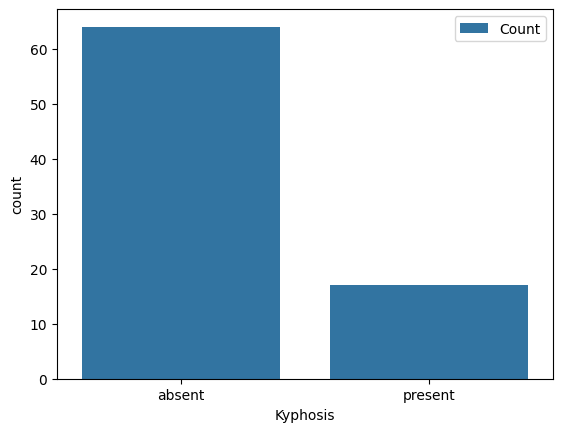

In [5]:
sns.countplot(data=df, x='Kyphosis', label = "Count")

### Formulación del modelo

In [6]:
X = df[['Age','Number','Start']]
y = df['Kyphosis']

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [8]:
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [9]:
encoder.classes_

array(['absent', 'present'], dtype=object)

In [10]:
y

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])

### Cross Validation

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

### Modelo Logístico

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

### Evaluación del Modelo

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [16]:
y_pred = clf.predict(X_test)

In [17]:
accuracy_score(y_test,y_pred)

0.72

In [18]:
confusion_matrix(y_test,y_pred)

array([[17,  2],
       [ 5,  1]])

## Balanceo de datos

In [19]:
# Revisar el desbalance de clases en el conjunto de entrenamiento
from collections import Counter

print("Distribución original en y_train (0 = clase mayoritaria, 1 = minoritaria):")
print(Counter(y_train))

Distribución original en y_train (0 = clase mayoritaria, 1 = minoritaria):
Counter({np.int64(0): 45, np.int64(1): 11})


In [20]:
# Aplicar una técnica de sobremuestreo (oversampling) sobre la clase minoritaria
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("Distribución balanceada en y_train_res:")
print(Counter(y_train_res))
X_train_res.shape

Distribución balanceada en y_train_res:
Counter({np.int64(0): 45, np.int64(1): 45})


(90, 3)

In [21]:
# Reentrenar el modelo logístico usando los datos balanceados
clf_bal = LogisticRegression()
clf_bal.fit(X_train_res, y_train_res)

# Predicciones en el mismo conjunto de test
y_pred_bal = clf_bal.predict(X_test)

print("Accuracy con datos balanceados:", accuracy_score(y_test, y_pred_bal))
print("Matriz de confusión con datos balanceados:")
print(confusion_matrix(y_test, y_pred_bal))

Accuracy con datos balanceados: 0.52
Matriz de confusión con datos balanceados:
[[ 9 10]
 [ 2  4]]


In [22]:
# Comparar rápidamente desempeño antes y después del balanceo
print("Accuracy sin balanceo :", accuracy_score(y_test, y_pred))
print("Accuracy con balanceo :", accuracy_score(y_test, y_pred_bal))

Accuracy sin balanceo : 0.72
Accuracy con balanceo : 0.52


### Comentarios sobre otros tipos de balanceo

Además del **oversampling aleatorio** que aplicamos (RandomOverSampler), existen otras estrategias de balanceo que es importante conocer:

- **Submuestreo (undersampling)**: se reduce el número de observaciones de la clase mayoritaria para que quede más cercana a la minoritaria.
  - Ventaja: el modelo se entrena más rápido y se equilibra la contribución de ambas clases.
  - Desventaja: se pierde información de la clase mayoritaria (podemos descartar ejemplos útiles).

- **Oversampling sintético (por ejemplo, SMOTE, ADASYN)**:
  - En lugar de copiar ejemplos de la clase minoritaria, generan **nuevas observaciones sintéticas** interpolando entre vecinos de la misma clase.
  - Suele ser más rico que el oversampling aleatorio, pero introduce ejemplos artificiales que deben revisarse con cuidado.

- **Ponderación de clases (`class_weight`)**:
  - En algunos modelos (Regresión Logística, Árboles, SVM, etc.) se puede usar `class_weight='balanced'` para penalizar más los errores sobre la clase minoritaria.
  - No cambia el número de filas, pero modifica la función de pérdida para que el modelo "preste más atención" a la clase rara.

En la práctica, la elección del método depende de:

- La cantidad de datos disponibles.
- La severidad del desbalance.
- La sensibilidad a perder información (undersampling) vs. introducir datos sintéticos (SMOTE).
- El tipo de modelo que estemos usando (algunos manejan mejor `class_weight` que el rebalanceo explícito de muestras).